En este proyecto vamos a trabajar sobre una clasificación de equipos de fútbol de la 3ª división alevín, fútbol 7, de la Federación Catalana de Fútbol, con un doble objetivo:
1. Poder predecir el ranking de cualquier equipo en base a las variables independientes disponibles.
2. Subdividir los equipos en varios nodos, en base a los resultados obtenidos, pero de manera transversal entre los distintos grupos.

# Importaciones y datos <a name="importacionesydatos"></a>

In [1]:
import pandas as pd

In [2]:
equipos = pd.read_csv('futbol.csv', sep=',')
equipos.rename(columns={'posicion': 'rank'}, inplace=True)

# Inspección de datos

In [3]:
pd.concat([equipos.head(1).round(1), equipos.tail(1).round(1)])

,grupo,rank,nombre,puntos,jug_loc,gan_loc,emp_loc,per_loc,jug_vis,gan_vis,emp_vis,per_vis,gol_fav,gol_con
0,1,1,Pª BARC. VILLAVERDE-PENITENTS A,34,6,5,0,1,7,6,1,0,99,19
403,29,14,"MOIA, C.E. C",0,6,0,0,6,7,0,0,7,17,106


Datos de clasificación de los 404 equipos de la liga de fútbol 7 sub-12, 3ª división - Federación Catalana de Fútbol.

In [4]:
equipos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   grupo    404 non-null    int64 
 1   rank     404 non-null    int64 
 2   nombre   404 non-null    object
 3   puntos   404 non-null    int64 
 4   jug_loc  404 non-null    int64 
 5   gan_loc  404 non-null    int64 
 6   emp_loc  404 non-null    int64 
 7   per_loc  404 non-null    int64 
 8   jug_vis  404 non-null    int64 
 9   gan_vis  404 non-null    int64 
 10  emp_vis  404 non-null    int64 
 11  per_vis  404 non-null    int64 
 12  gol_fav  404 non-null    int64 
 13  gol_con  404 non-null    int64 
dtypes: int64(13), object(1)
memory usage: 44.3+ KB


404 filas y 14 columnas, ningún registro nulo, 12 de tipo entero y 1 de tipo objeto / string. `grupo`, aunque numérica, tiene naturaleza categórica.

In [5]:
equipos.duplicated().sum()

0

No existen registros duplicados.

Convertimos las variables en variables por partido y añadimos la columna `dif_gol` (diferencia de goles):

In [6]:
columnas_loc = ['gan_loc', 'per_loc', 'emp_loc']
columnas_vis = ['gan_vis', 'per_vis', 'emp_vis']
columnas_gol = ['gol_fav', 'gol_con']

equipos['puntos'] = equipos['puntos'] / (equipos['jug_loc'] + equipos['jug_vis'])

for l in columnas_loc:
  equipos[l] = equipos[l] / equipos['jug_loc']

for v in columnas_vis:
  equipos[v] = equipos[v] / equipos['jug_vis']

for g in columnas_gol:
  equipos[g] = equipos[g] / (equipos['jug_loc'] + equipos['jug_vis'])

equipos['dif_gol'] = equipos['gol_fav'] - equipos['gol_con']
equipos.drop(['jug_loc','jug_vis'], axis = 1, inplace=True)

... y eliminamos las columnas `jug_loc` y `jug_vis`.

Resultados por partido:

In [7]:
equipos.head(1).round(2)

,grupo,rank,nombre,puntos,gan_loc,emp_loc,per_loc,gan_vis,emp_vis,per_vis,gol_fav,gol_con,dif_gol
0,1,1,Pª BARC. VILLAVERDE-PENITENTS A,2.62,0.83,0.0,0.17,0.86,0.14,0.0,7.62,1.46,6.15


Datos curiosos:

In [8]:
equipos.drop(['nombre','grupo'], axis = 1).describe().round(3)

,rank,puntos,gan_loc,emp_loc,per_loc,gan_vis,emp_vis,per_vis,gol_fav,gol_con,dif_gol
count,404.000,404.000,404.000,404.000,404.000,404.000,404.000,404.000,404.000,404.000,404.000
mean,7.537,1.469,0.494,0.056,0.449,0.449,0.057,0.494,4.158,4.157,0.001
std,4.134,0.855,0.307,0.090,0.307,0.308,0.094,0.314,2.181,2.186,4.128
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.467,0.214,-9.000
25%,4.000,0.773,0.286,0.000,0.167,0.143,0.000,0.286,2.396,2.500,-2.950
50%,7.000,1.467,0.500,0.000,0.429,0.429,0.000,0.500,3.810,3.857,0.033
75%,11.000,2.200,0.750,0.143,0.714,0.714,0.143,0.714,5.600,5.649,2.801
max,16.000,3.000,1.000,0.429,1.000,1.000,0.500,1.000,10.071,9.714,9.500


---------------------------------------------------------------------

- En media se gana algo más como local que como visitante (49% - 45%).
- Se empatan apenas el 1% de los partidos.
- Se marcan 4 goles por partido y equipo, con un ligero sesgo positivo.

Interpretación:

- Victoria = 3 puntos, empate = 1 punto.
- Longitud del campo: 50 - 65 m. 7 jugadores por equipo.
- Duración de un partido: 60' (4 x 15').

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [10]:
equipos_loc = equipos[['gan_loc', 'per_loc']]

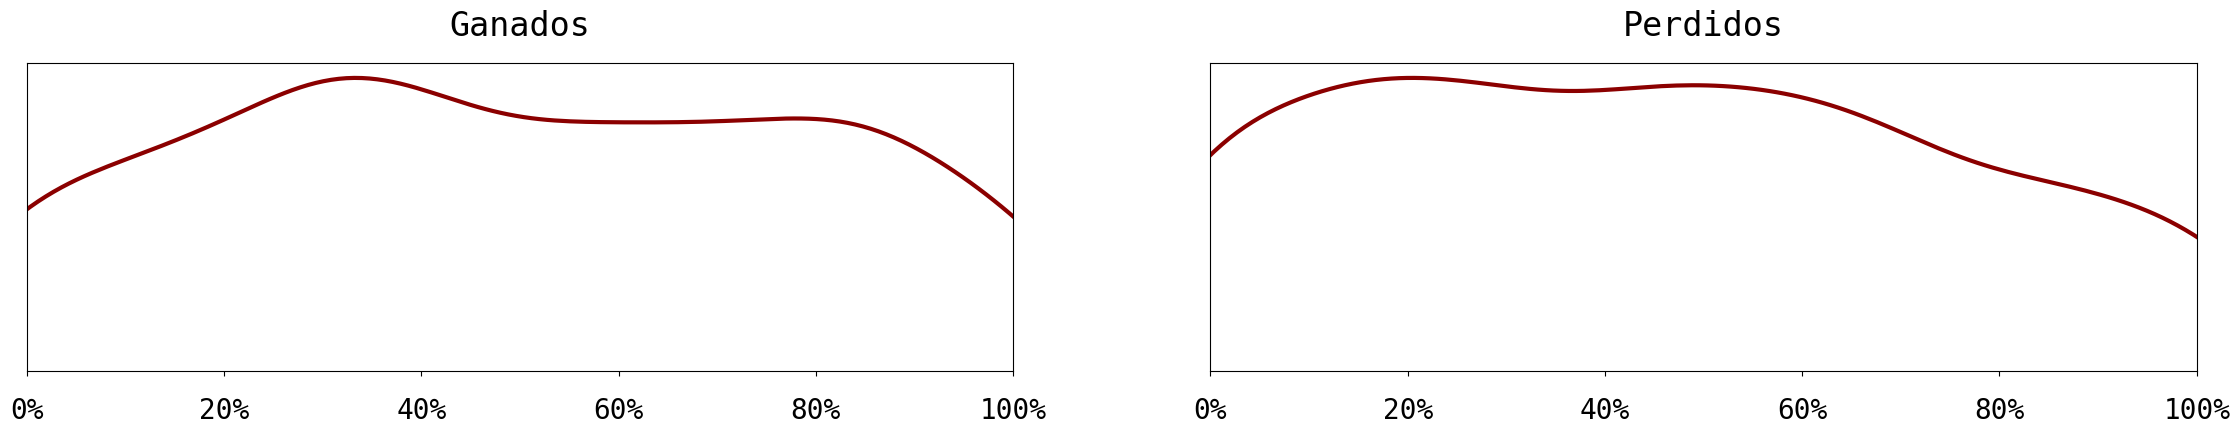

In [11]:
from matplotlib.ticker import PercentFormatter

plt.rcParams['font.family'] = 'monospace'

fig, axes = plt.subplots(1, 2, figsize=(28, 4))
axes = axes.flatten()
titulos = ['Ganados', 'Perdidos']

i = 0

for v in equipos_loc.describe():
  sns.kdeplot(equipos_loc[v], ax=axes[i], linewidth=3, color='darkred')
  axes[i].set_title(titulos[i % len(titulos)], fontsize=24, pad=20)
  axes[i].set_xlabel('', fontsize=20)
  axes[i].set_ylabel('')
  axes[i].set_yticks([])
  axes[i].xaxis.set_major_formatter(PercentFormatter(1))
  axes[i].tick_params(axis='x', labelsize=20, pad=15)
  axes[i].set_xlim(0, 1)
  i +=1

Densidad para porcentaje de victorias y derrotas.

In [12]:
equipos_gol = equipos[['gol_fav', 'gol_con']]

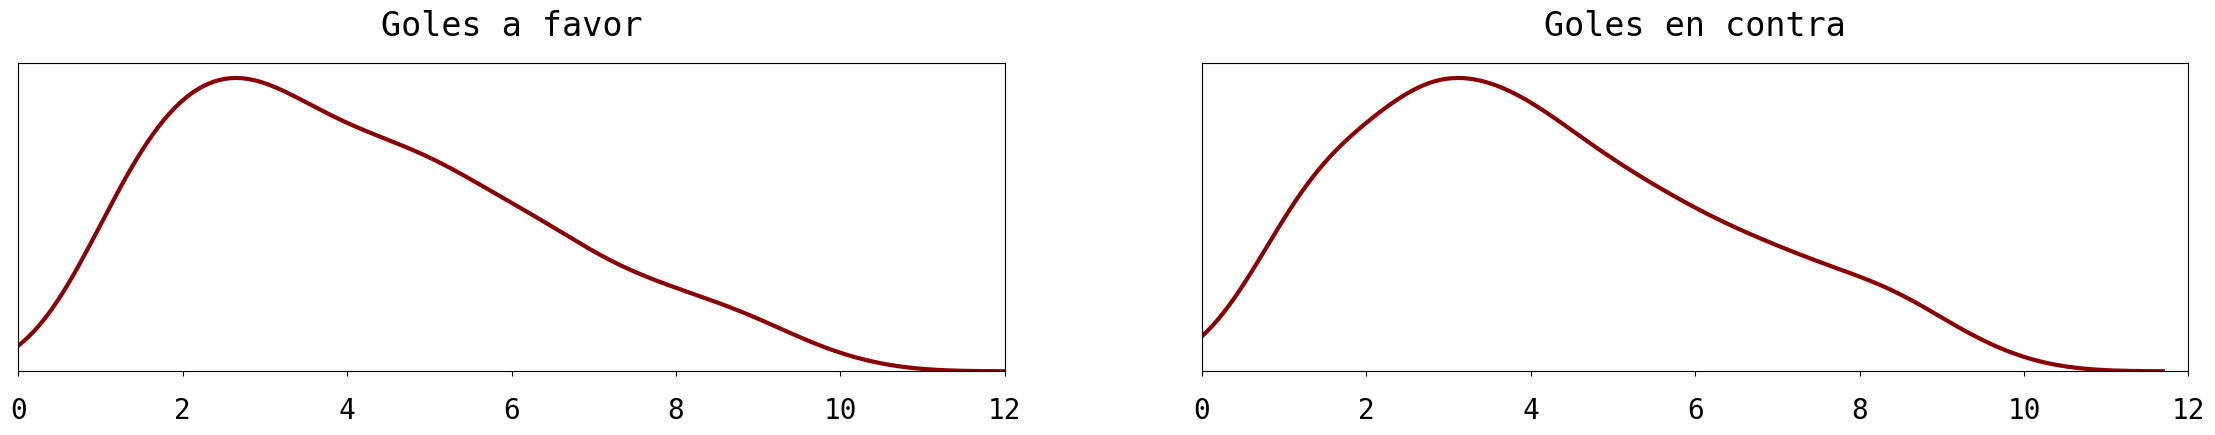

In [13]:
plt.rcParams['font.family'] = 'monospace'

fig, axes = plt.subplots(1, 2, figsize=(28, 4))
axes = axes.flatten()
titulos = ['Goles a favor', 'Goles en contra']

i = 0

for e in equipos_gol.describe():
  sns.kdeplot(equipos_gol[e], ax=axes[i], linewidth=3, color='darkred')
  axes[i].set_title(titulos[i % len(titulos)], fontsize=24, pad=20)
  axes[i].set_xlabel('', fontsize=20)
  axes[i].set_ylabel('')
  axes[i].set_yticks([])
  axes[i].tick_params(axis='x', labelsize=20, pad=15)
  axes[i].set_xlim(0, 12)
  i +=1

Densidad de goles a favor y en contra. Sesgo positivo.

Interpretación:

- Límite en diferencia de 10 goles (FCF).

Mejores equipos de la competición:

In [14]:
max_punt = equipos['puntos'].max()
equipos_top = equipos[equipos['puntos'] == max_punt].round(2)
equipos_top

,grupo,rank,nombre,puntos,gan_loc,emp_loc,per_loc,gan_vis,emp_vis,per_vis,gol_fav,gol_con,dif_gol
103,8,1,"SABADELL NORD,CF. A",3.0,1.0,0.0,0.0,1.0,0.0,0.0,7.53,1.13,6.40
117,9,1,"SABADELLENCA, UE. B",3.0,1.0,0.0,0.0,1.0,0.0,0.0,9.93,0.71,9.21
170,13,1,LLIÇA DE VALL C.F. C,3.0,1.0,0.0,0.0,1.0,0.0,0.0,9.40,0.93,8.47
207,16,1,"CALELLA, C.F. A",3.0,1.0,0.0,0.0,1.0,0.0,0.0,7.43,1.14,6.29
238,18,1,SINERA UNITED FUTBOL CLUB ASS. C,3.0,1.0,0.0,0.0,1.0,0.0,0.0,9.40,0.67,8.73
269,20,1,"MOLINS DE REI, C.F. B",3.0,1.0,0.0,0.0,1.0,0.0,0.0,8.57,0.57,8.00
284,21,1,"ALMEDA, C.D. A",3.0,1.0,0.0,0.0,1.0,0.0,0.0,9.71,0.21,9.50
314,23,1,COL.LEGI SAGRAT COR SARRIA AMPA A,3.0,1.0,0.0,0.0,1.0,0.0,0.0,9.31,1.08,8.23
328,24,1,"ATENEU IGUALADI, S.E.F. A",3.0,1.0,0.0,0.0,1.0,0.0,0.0,8.57,1.07,7.50
339,25,1,"LES CABANYES, F.C. A",3.0,1.0,0.0,0.0,1.0,0.0,0.0,7.08,0.85,6.23


12 equipos con 3 puntos por partido.

In [15]:
equipos[equipos['gol_fav'] == equipos['gol_fav'].max()].round(2)

,grupo,rank,nombre,puntos,gan_loc,emp_loc,per_loc,gan_vis,emp_vis,per_vis,gol_fav,gol_con,dif_gol
90,7,1,ARISTOI FOOTBALL ACADEMY A,2.79,1.0,0.0,0.0,0.86,0.0,0.14,10.07,3.0,7.07


ARISTOI FOOTBALL ACADEMY A, máximo registro de goles por partido, 10.07.

In [16]:
equipos[equipos['gol_con'] == equipos['gol_con'].min()].round(2)

,grupo,rank,nombre,puntos,gan_loc,emp_loc,per_loc,gan_vis,emp_vis,per_vis,gol_fav,gol_con,dif_gol
284,21,1,"ALMEDA, C.D. A",3.0,1.0,0.0,0.0,1.0,0.0,0.0,9.71,0.21,9.5


ALMEDA, C.D. A, mínimo registro de goles recibidos por partido, 0.21.

In [17]:
max_dif_gol = (equipos_top['gol_fav'] - equipos_top['gol_con']).max()
equipo_top = equipos_top[(equipos_top['gol_fav'] - equipos_top['gol_con']) == max_dif_gol]
equipo_top.round(2)

,grupo,rank,nombre,puntos,gan_loc,emp_loc,per_loc,gan_vis,emp_vis,per_vis,gol_fav,gol_con,dif_gol
284,21,1,"ALMEDA, C.D. A",3.0,1.0,0.0,0.0,1.0,0.0,0.0,9.71,0.21,9.5


Almeda C.D. A, mejor diferencia de goles por partido, 9.5.



In [18]:
equipos_top_dif = pd.DataFrame()
dif_top = (equipos_top['gol_fav'] - equipos_top['gol_con']).mean().round(3)

for e in equipos_top:
  equipos_top_dif['nombre'] = equipos_top['nombre']
  dif_gol = equipos_top['gol_fav'] - equipos_top['gol_con']
  equipos_top_dif['dif_gol'] = (dif_gol - dif_top).round(1)

equipos_top_dif.sort_values(by='dif_gol', ascending=False)

,nombre,dif_gol
284,"ALMEDA, C.D. A",1.9
117,"SABADELLENCA, UE. B",1.6
238,SINERA UNITED FUTBOL CLUB ASS. C,1.1
170,LLIÇA DE VALL C.F. C,0.9
314,COL.LEGI SAGRAT COR SARRIA AMPA A,0.6
269,"MOLINS DE REI, C.F. B",0.4
328,"ATENEU IGUALADI, S.E.F. A",-0.1
375,CASTELLNOU UNIÓ ESPORTIVA CLUB FUTBOL A,-1.0
103,"SABADELL NORD,CF. A",-1.2
207,"CALELLA, C.F. A",-1.3


CD Almeda A, UE Sabadellenca B y Sinera United FC C, mejor diferencia de goles por partido entre los equipos ***top***: 1.9 - 1.6 - 1.1.

In [19]:
from matplotlib.colors import LinearSegmentedColormap

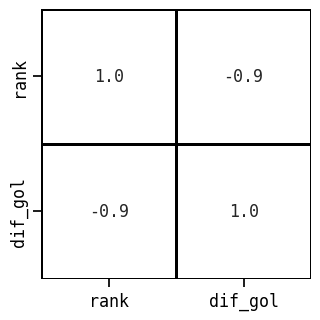

In [20]:
sns.set_context('notebook')

corr_matrix = equipos[['rank', 'dif_gol']].corr().round(1)

colors = ["white", "grey", "darkgray", "grey", "white"]
n_bins = 100
cmaps = LinearSegmentedColormap.from_list(name='custom_grey', colors=colors, N=n_bins)

plt.figure(figsize=(3.5, 3.5))
sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap=cmaps, square=True, linewidths=1, linecolor='black', cbar=False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

Correlación entre diferencia de goles y ranking: 0.9.

# Transformación de datos

Separamos primero nuestra variable dependiente de las independientes:

In [21]:
X = equipos.drop(['grupo', 'rank', 'nombre', 'puntos', 'gol_fav', 'gol_con'], axis=1)
y = equipos['rank']

In [22]:
from sklearn.model_selection import train_test_split

... y los subconjuntos de entrenamiento y prueba:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

Para decidir el tipo de transformación adecuado, primero debemos comprobar la normalidad y la presencia de valores extremos:

In [24]:
from scipy.stats import shapiro

In [25]:
for x in X_train:
  stat, p = shapiro(X_train[x])
  if p > 0.05:
    print(x+': Gaussiana'+' - p = '+f"{p:.3f}")
  else:
    print(x+': No gaussiana'+' - p = '+f"{p:.3f}")

gan_loc: No gaussiana - p = 0.000
emp_loc: No gaussiana - p = 0.000
per_loc: No gaussiana - p = 0.000
gan_vis: No gaussiana - p = 0.000
emp_vis: No gaussiana - p = 0.000
per_vis: No gaussiana - p = 0.000
dif_gol: No gaussiana - p = 0.001


... ninguna de las variables independientes es gaussiana ...

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

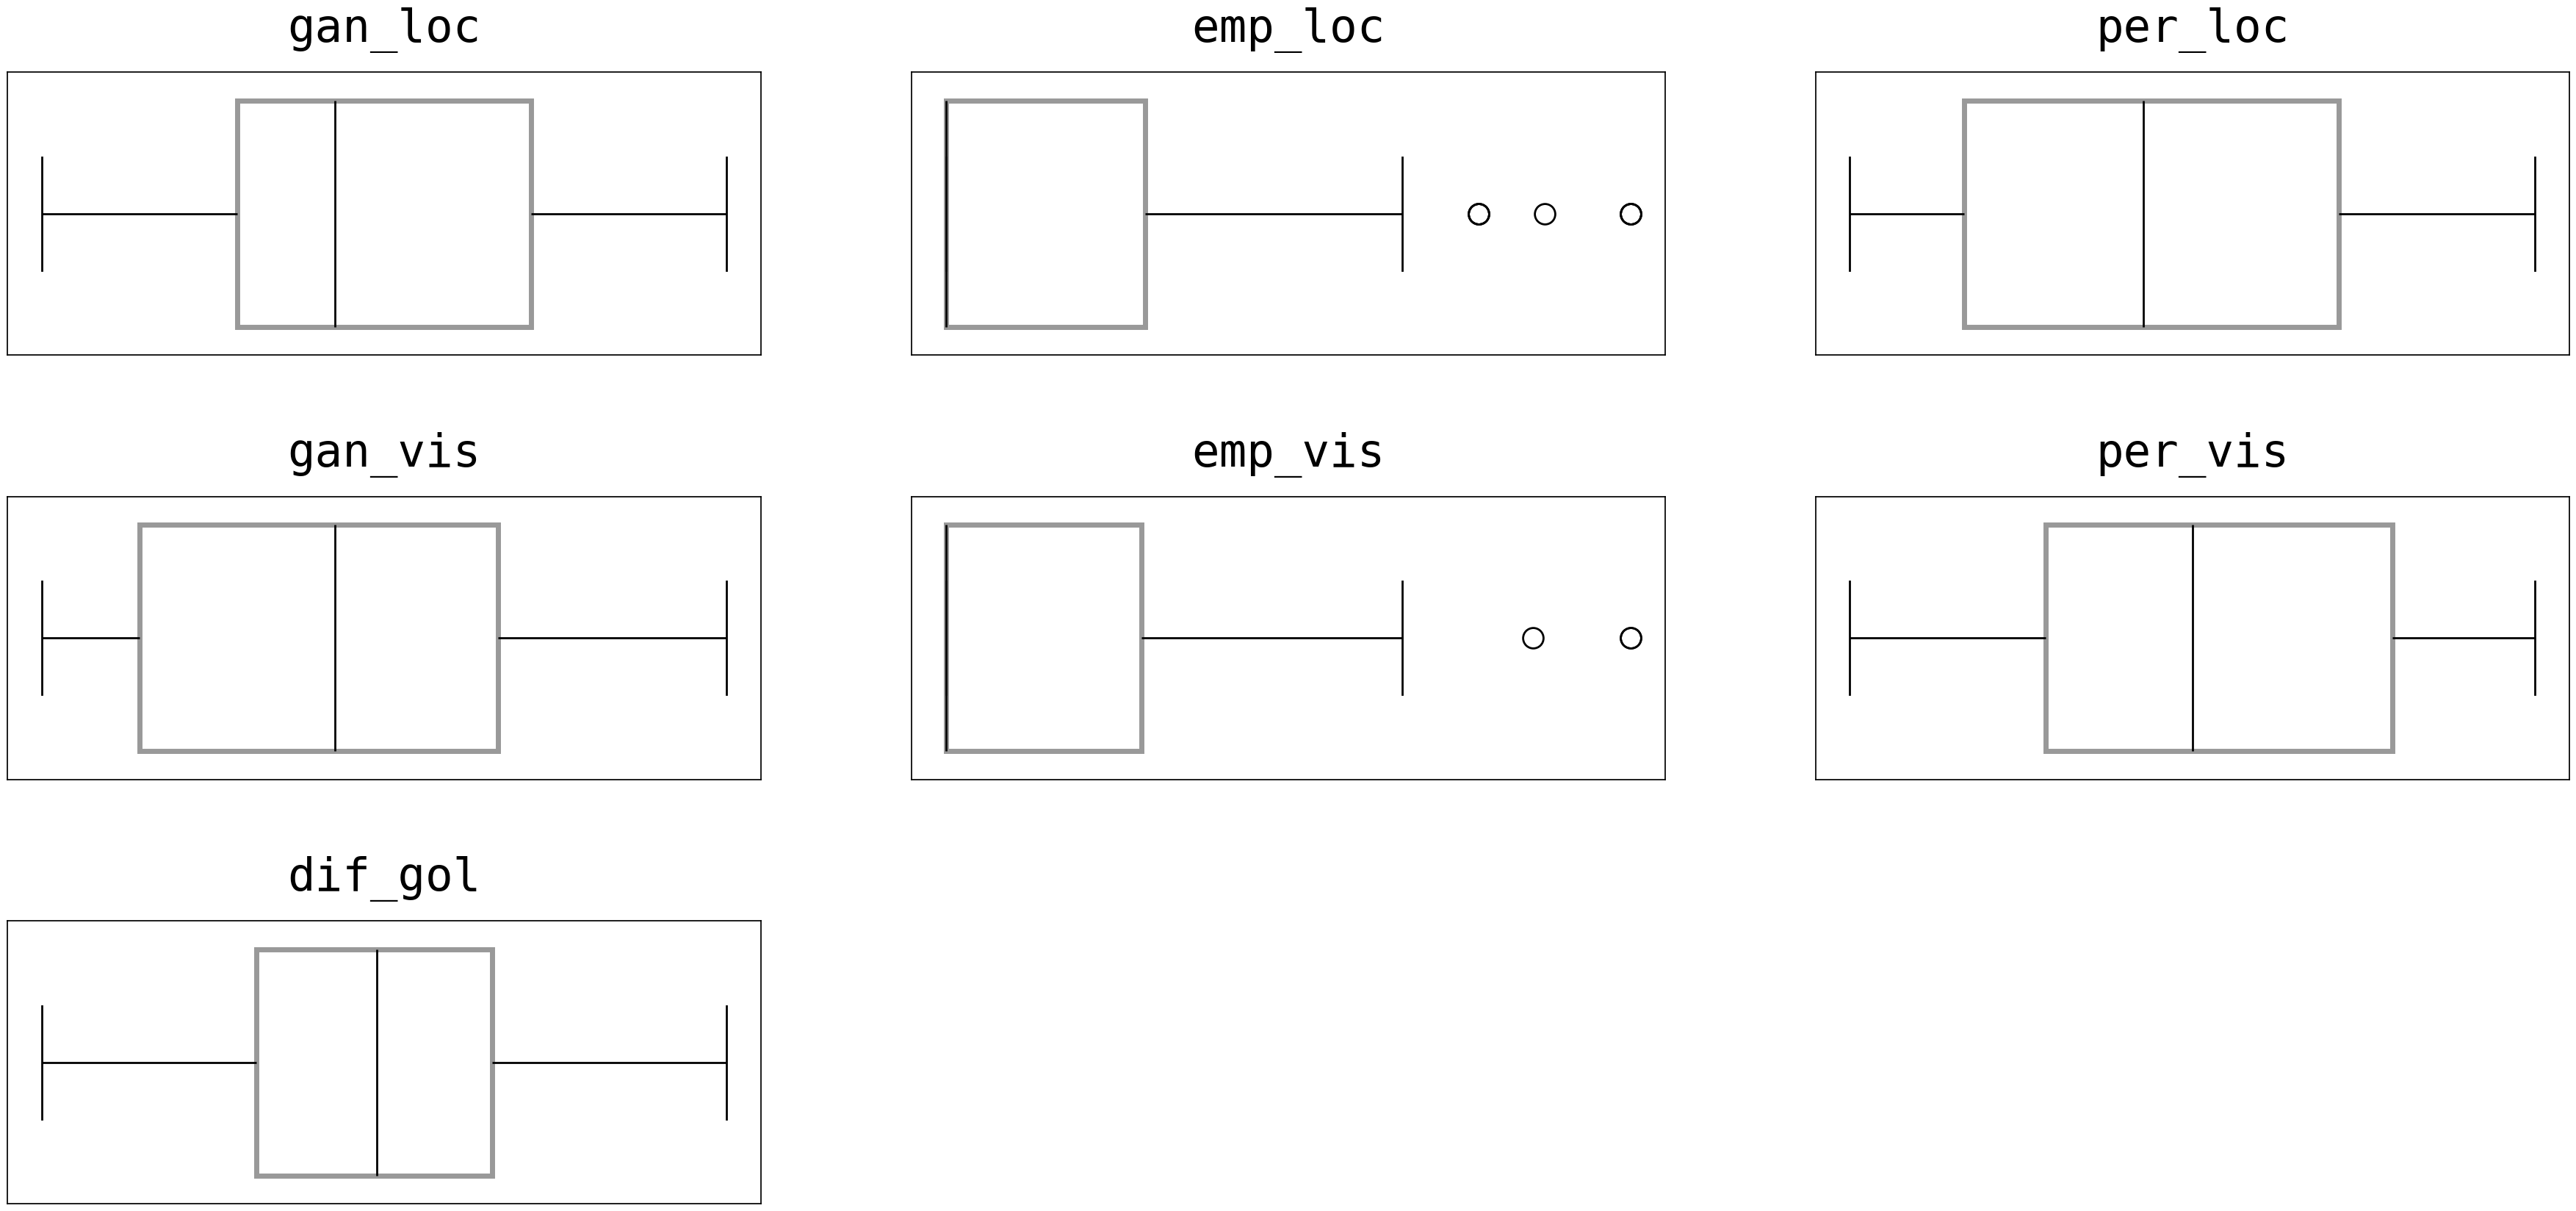

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(45, 20))
axes = axes.flatten()

flierprops = dict(marker='o', markersize=20, linestyle='none', markeredgecolor='black',
                  markeredgewidth=2)
line_properties = dict(color='black', linewidth=2)

i = 0
for x in X_train:
  sns.boxplot(X_train[x], ax=axes[i], orient='h', color='white', linewidth=5,
              flierprops=flierprops, whiskerprops=line_properties, capprops=line_properties,
              medianprops=line_properties)
  axes[i].set_title(x, fontsize=45, pad=30)
  axes[i].set_xlabel('')
  axes[i].set_ylabel('')
  axes[i].set_xticks([])
  axes[i].set_yticks([])
  i +=1

plt.subplots_adjust(hspace=0.5)
axes[7].set_visible(False)
axes[8].set_visible(False)

... y dos de ellas: `emp_loc` y `emp_vis` presentan valores extremos.

Un breve recordatorio:

| Tipo de Dato                | Condición           | Transformación Recomendada |
|-----------------------------|---------------------|---------------------------|
| Datos con Distribución Gaussiana | -                 | `StandardScaler`          |
| Datos con Distribución No Gaussiana | Sin Outliers   | `MinMaxScaler`            |
| Datos con Distribución No Gaussiana | Con Outliers   | `RobustScaler`            |
| Categóricas sin Jerarquía    | -                   | `OneHotEncoder` / `pd.get_dummies()` |
| Categóricas con Jerarquía    | -                   | `LabelEncoder`            |

Por lo tanto, debemos normalizar con `MinMaxScaler` -> `gan_loc`, `per_loc`, `gan_vis`, `per_vis`, `gol_fav`, `gol_con`, y con `RobustScaler` -> `emp_loc` y `emp_vis`.

... vamos con ello:

In [28]:
X_train_esc = pd.DataFrame()
X_test_esc = pd.DataFrame()

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
min_max_cols = ['gan_loc', 'per_loc', 'gan_vis', 'per_vis', 'dif_gol']

for i in min_max_cols:
  X_train_min_max = scaler.fit_transform(X_train[[i]]).reshape(-1)
  X_train_min_max_pd = pd.Series(X_train_min_max)
  X_train_esc[i] = X_train_min_max_pd
  X_test_min_max = scaler.transform(X_test[[i]]).reshape(-1)
  X_test_min_max_pd = pd.Series(X_test_min_max)
  X_test_esc[i] = X_test_min_max_pd

In [30]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
robust_cols = ['emp_loc', 'emp_vis']

for i in robust_cols:
  X_train_robust = scaler.fit_transform(X_train[[i]]).reshape(-1)
  X_train_robust_pd = pd.Series(X_train_robust)
  X_train_esc[i] = X_train_robust_pd
  X_test_robust = scaler.transform(X_test[[i]]).reshape(-1)
  X_test_robust_pd = pd.Series(X_test_robust)
  X_test_esc[i] = X_test_robust_pd

Subconjuntos de entrenamiento y prueba escalados: X_train_esc y X_test_esc.

Nos queda encontrar el modelo que mejor se ajuste y con mayor precisión nos permita predecir nuestros datos.

# Selección de modelo

Buscamos el modelo de aprendizaje automático que mejor se pueda ajustar a nuestros datos:

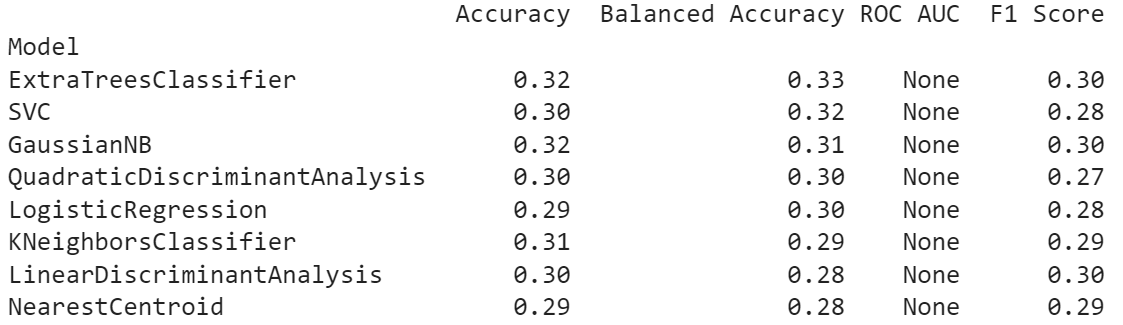

In [31]:
from IPython.display import Image, display
display(Image('lazy_predict.png', width=540, height=220))

Modelos de clasificación con varianza explicada por debajo del 32%.

In [32]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
regr = MLPRegressor(random_state=1, max_iter=1000).fit(X_train, y_train)
regr.predict(X_test[:2])
regr.score(X_test, y_test).round(4)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9

Modelo de red neuronal con varianza explicada del 90%.

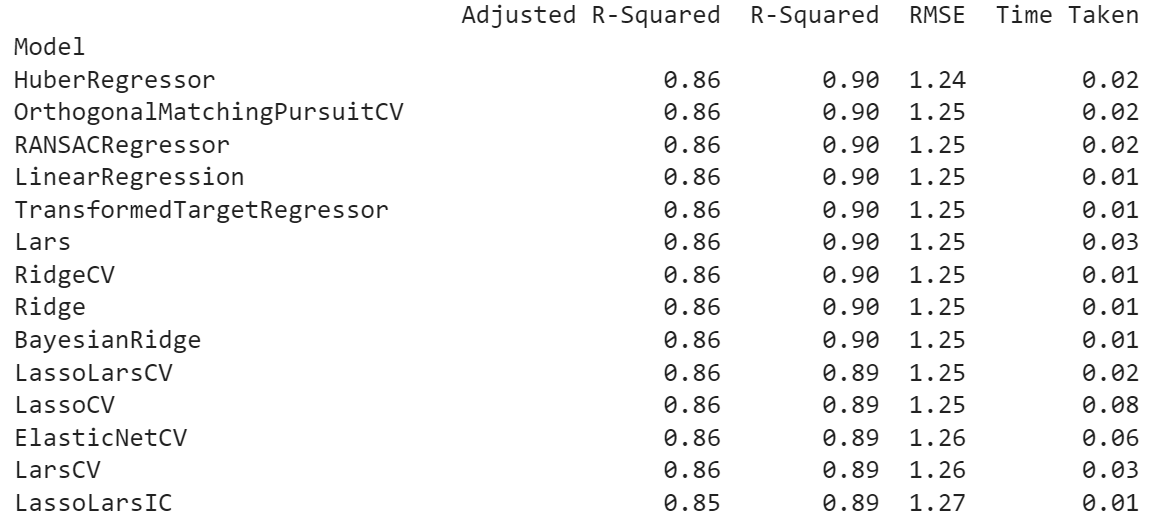

In [33]:
from IPython.display import Image, display
display(Image('lazy_predict_reg.png', width=640, height=330))

Modelo de regresión lineal con varianza explicada del 90%, que en principio parece suficientemente bueno.

Pero de todos modos, hay que vigilar lo multicolinealidad entre las variables, y para ello vamos a hacer un par de aproximaciones a su estudio.

1. Matriz de correlaciones:

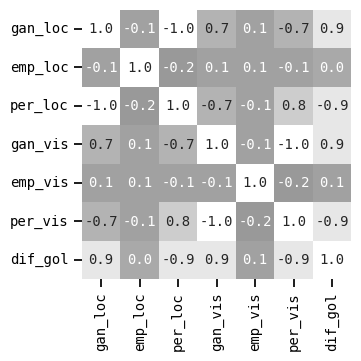

In [34]:
sns.set_context('notebook')

corr_matrix = X_train.corr().round(1)

colors = ["white", "grey", "darkgray", "grey", "white"]
cmaps = LinearSegmentedColormap.from_list(name='custom_grey', colors=colors)

plt.figure(figsize=(3.5, 3.5))
sns.heatmap(corr_matrix, annot=True, fmt='.1f', square=True, cmap=cmaps, linecolor='black',
            cbar=False, annot_kws={"size": 10})

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Por un lado vemos como `dif_gol` es la más correlacionada con las demás variables, y por otro la correlación entre los partidos ganados y perdidos en casa y fuera es lógicamente perfecta.

Por otro lado el factor de inflación de la varianza explicada nos muestra lo siguiente ...

In [35]:
import statsmodels.api as sm

In [36]:
Z_train = X_train_esc.drop(['per_loc', 'per_vis'], axis=1)
Z_test = X_test_esc.drop(['per_loc', 'per_vis'], axis=1)
Z_train = sm.add_constant(Z_train)
Z_test = sm.add_constant(Z_test)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [38]:
vif = pd.DataFrame()
vif[''] = Z_train.columns
vif['VIF'] = [variance_inflation_factor(Z_train.values, i) for i in range(Z_train.shape[1])]
print(vif)

                  VIF
0    const   8.134313
1  gan_loc   7.055540
2  gan_vis   6.314240
3  dif_gol  15.836779
4  emp_loc   1.206756
5  emp_vis   1.137923


Efectivamente el grado de colinealidad de la diferencia de goles con el resto de variables es muy alto, se considera ya alto entre 5 y 10. Mientras los empates son los menos correlacionados con el resto de variables.

Visto lo anterior podemos tomar dos medidas ya, la primera es prescindir de la variable dif_gol, y la segunda combinar las variables gan_loc y gan_vis, haciendo una media entre las dos. Vamos con ello:

In [39]:
X_train_esc.drop(['dif_gol','per_loc', 'per_vis'], axis=1, inplace=True)
X_test_esc.drop(['dif_gol', 'per_loc', 'per_vis'], axis=1, inplace=True)

In [40]:
X_train_esc['gan'] = (X_train_esc['gan_loc'] + X_train_esc['gan_vis'])/2
X_test_esc['gan'] = (X_test_esc['gan_loc'] + X_test_esc['gan_vis'])/2

In [41]:
X_train_esc.drop(['gan_loc','gan_vis'], axis=1, inplace=True)
X_test_esc.drop(['gan_loc', 'gan_vis'], axis=1, inplace=True)

In [42]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [43]:
modelo = LinearRegression().fit(X_train_esc, y_train)

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

modelo_grid = GridSearchCV(modelo, param_grid)
modelo_grid.fit(X_train_esc, y_train)
print("Mejores parámetros:", modelo_grid.best_params_)

Mejores parámetros: {'fit_intercept': True, 'positive': False}


In [46]:
modelo_opt = LinearRegression(fit_intercept=True, positive=False).fit(X_train_esc, y_train)

In [47]:
print('Regresión lineal, 3 variables independientes, R2: '+str(modelo_opt.score(X_test_esc, y_test).round(3)))

Regresión lineal, 3 variables independientes, R2: 0.903


Vemos como el rendimiento del modelo utilizando solamente 3 variables, siendo una de ellas una combinación de otras dos previas, es el mismo que cuando utilizábamos 7 variables.

In [48]:
W_train = X_train_esc
W_test = X_test_esc
W_train = sm.add_constant(W_train)
W_test = sm.add_constant(W_test)

In [49]:
vif = pd.DataFrame()
vif[''] = W_train.columns
vif['VIF'] = [variance_inflation_factor(W_train.values, i) for i in range(W_train.shape[1])]
print(vif)

                 VIF
0    const  4.318667
1  emp_loc  1.009402
2  emp_vis  1.008284
3      gan  1.002323


... y comprobamos como el factor de inflación de la varianza es ahora sí mínimo.

In [50]:
X_min_train_esc = X_train_esc.drop(['emp_loc','emp_vis'], axis=1)
X_min_test_esc = X_test_esc.drop(['emp_loc', 'emp_vis'], axis=1)

In [51]:
modelo_min = LinearRegression().fit(X_min_train_esc, y_train)

In [52]:
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

modelo_min_grid = GridSearchCV(modelo_min, param_grid)
modelo_min_grid.fit(X_min_train_esc, y_train)
print("Mejores parámetros:", modelo_min_grid.best_params_)

Mejores parámetros: {'fit_intercept': True, 'positive': False}


In [53]:
modelo_min_opt = LinearRegression(fit_intercept=True, positive=False)\
.fit(X_min_train_esc, y_train)

In [54]:
print('Regresión lineal, 3 variables independientes, R2: '+str(modelo_min_opt.score(X_min_test_esc, y_test).round(3)))

Regresión lineal, 3 variables independientes, R2: 0.897


... y yendo un paso más allá, eliminando también los empates, el rendimiento sigue siendo prácticamente el mismo, 89.7%.

Todo lo anterior significa que podemos predecir la clasificación de los equipos con un modelo de regresión lineal con un sólo parámetro, que combina las victorias como local y como visitante, prescindiendo de todas las demás variables, con bastante exactitud.

Veamos un ejemplo:

In [55]:
import pandas as pd

def predecir_clasificacion(modelo, ind_vic):
    datos_para_prediccion = pd.DataFrame({'gan': [ind_vic]})
    prediccion = modelo.predict(datos_para_prediccion).round(1)
    pos = int(prediccion[0])
    return pos

ind_vic = 0.9
rank = predecir_clasificacion(modelo_min_opt, ind_vic)
if rank < 1:
  rank = 1
print("La clasificación predicha es: "+str(rank)+"º")

La clasificación predicha es: 1º


Modificando el parámetro ind_vic (valores entre 0 y 1), podemos obtener la predicción de nuestro modelo de regresión lineal.

# Cross-validation

Finalmente, podemos evaluar los rendimientos del modelo utilizando la validación cruzada:

In [56]:
X_combinada = pd.concat([X_min_train_esc, X_min_test_esc])
y_combinada = pd.concat([y_train, y_test])

Recuperamos los datos mínimos transformados, es decir, aquellos que sólo incluyen una variable independiente.

In [57]:
from sklearn.model_selection import cross_val_score

cross_tree = cross_val_score(modelo_min_opt, X_combinada, y_combinada, cv=5)
print(cross_tree)

[0.90810109 0.90824179 0.93279942 0.9093283  0.89677121]


Y vemos como efectivamente el modelo lineal explica el 90% de la varianza.

# 2. División en grupos (clustering)

Aprovechando el estudio previo realizado para el modelo de regresión podemos también ajustar un modelo de clústering, que nos permita aproximar a los equipos de manera transversal entre los distintos grupos.

In [58]:
X_combinada = X_combinada.reset_index(drop=True)
y_combinada = y_combinada.reset_index(drop=True)

Trabajamos con los datos reducidos (a dos variables, una dependiente y una independiente).

In [59]:
X_combinada = X_combinada.squeeze()
y_combinada = y_combinada.squeeze()

In [60]:
data = pd.DataFrame({'Victorias': X_combinada, 'Posicion': y_combinada})

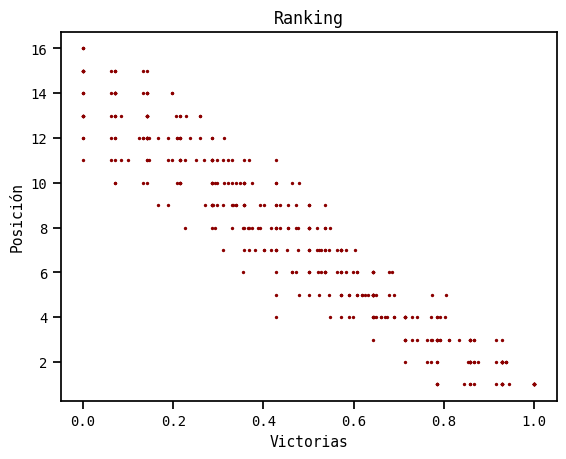

In [61]:
plt.scatter(data['Victorias'], data['Posicion'], s=2, color = 'darkred')
plt.xlabel('Victorias', size=10.5)
plt.ylabel('Posición', size=10.5)
plt.title('Ranking')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

Utilizando el modelo K-means para distintos números de clústers podemos evaluar el rendimiento mediante SSE (suma de errores al cuadrado - distancias de los puntos al nodo central de cada clúster elevadas al cuadrado y sumadas):

In [62]:
from sklearn.cluster import KMeans

In [63]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 1,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)

Ahora que tenemos todos los errores en sse, los podemos mostrar en un gráfico:

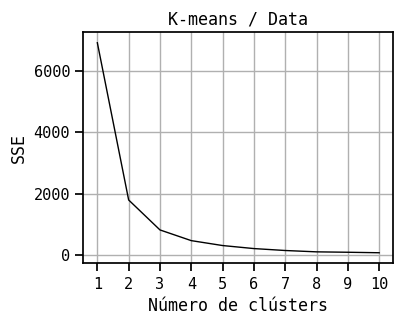

In [64]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(range(1, 11), sse, color='black', lw=1)
ax.set_xticks(range(1, 11))
ax.set_xlabel("Número de clústers")
ax.set_ylabel("SSE")
ax.set_title("K-means / Data")
plt.grid(True)
plt.show()

Podemos ver como el punto del codo, que se suele considerar el óptimo para equilibrar número de clústers (cuanto menor mejor), y error SSE (cuando menor mejor), se encuentra en 2, 3 o 4 clústers. Por lo tanto necesitamos todavía un cálculo preciso ...

In [65]:
pip install kneed

In [66]:
from kneed import KneeLocator

In [67]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

... y lo obtenemos en el paquete kneed, clase KneeLocator, utilizando el método elbow, que nos da el punto exacto del codo, en este caso 3 clústeres.

In [68]:
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(data)
data['Cluster'] = kmeans.labels_

Aquí ya hemos obtenido una etiqueta para cada equipo, clasificándolo en uno de entre los 3 clústers.

Obteniendo la siguiente distribución:

In [69]:
clusters = data[['Posicion', 'Cluster']].value_counts().reset_index()
clusters.columns = ['Posicion', 'Cluster', 'Conteo']

In [70]:
etiquetas = {0: 0, 2: 1, 1: 2}
clusters.Cluster = clusters.Cluster.map(etiquetas)

In [71]:
clusters

,Posicion,Cluster,Conteo
0,1,2,29
1,2,2,29
2,3,2,29
3,4,2,29
4,5,2,29
5,6,0,29
6,7,0,29
7,8,0,29
8,9,0,29
9,10,0,29


La interpretación ahora es sencilla, `kmeans` distribuye los equipos en tres grupos (clústers), donde la variable determinante es la posición que ocupan en la tabla:
- Clúster 0: 1-5.
- Clúster 1: 6-10.
- Clúster 2: 11-16.

Finalmente podemos obtener el rendimiento del algoritmo `kmeans` para unir de manera transversal a los equipos de los 29 grupos de nuestra liga, utilizando el método Silhouette, de la librería sklearn, siendo el siguiente:

In [72]:
from sklearn.metrics import silhouette_score

In [73]:
score = silhouette_score(data, kmeans.labels_).round(3)

print('Silhouette kmeans con 3 clústers: '+str(score))

Silhouette kmeans con 3 clústers: 0.63


Si bien un rendimiento de Silhouette de 0.61 no se puede considerar muy alto en términos generales, conociendo nuestra liga (grupo 17) parece acertado, en tanto los equipos que ocupan las posiciones 1 - 5 se destacan en nivel y registros de los equipos que les siguen, del mismo modo que los equipos que ocupan las posiciones 6 - 10, se destacan de los que les siguen, siendo la evidencia más clara la diferencia de puntos por partido.

In [74]:
equipos[equipos['grupo'] == 17].round(2)

,grupo,rank,nombre,puntos,gan_loc,emp_loc,per_loc,gan_vis,emp_vis,per_vis,gol_fav,gol_con,dif_gol
222,17,1,JOVENTUT TEIA CLUB FUTBOL B,2.87,1.00,0.00,0.00,0.86,0.14,0.00,8.53,1.40,7.13
223,17,2,ROCAFONDA CLUB FUTBOL A,2.60,1.00,0.00,0.00,0.71,0.00,0.29,6.87,1.27,5.60
224,17,3,"PREMIA DALT, C.D. C",2.60,1.00,0.00,0.00,0.71,0.00,0.29,7.13,1.93,5.20
225,17,4,"JUVENTUS, A.C. B",2.47,0.86,0.14,0.00,0.75,0.00,0.25,6.20,1.00,5.20
226,17,5,"VILASSAR MAR,U.E. C",2.40,0.78,0.00,0.22,0.83,0.00,0.17,6.93,2.87,4.07
227,17,6,"ARGENTONA, C.F. B",1.87,0.57,0.00,0.43,0.62,0.12,0.25,3.00,2.73,0.27
228,17,7,FUNDACIÓ ESPORTIVA MONTGAT B,1.60,0.57,0.00,0.43,0.50,0.00,0.50,5.40,5.67,-0.27
229,17,8,"HAMELIN-LAIE, C.E. A",1.53,0.29,0.29,0.43,0.62,0.00,0.38,4.87,4.93,-0.07
230,17,9,"CALELLA, C.F. B",1.40,0.38,0.00,0.62,0.57,0.00,0.43,4.73,3.20,1.53
231,17,10,"MASNOU, C.D. B",1.40,0.43,0.00,0.57,0.50,0.00,0.50,3.47,5.13,-1.67


Es decir, de alguna manera volvemos al principio. Hemos visto como prescindiendo de prácticamente todas las variables, incluyendo los puntos por partido, y solamente utilizando la media de victorias de los equipos, como local y como visitante, no sólo podemos obtener la clasificación de cada equipo de manera bastante precisa utilizando un sencillo modelo de regresión lineal, sino que además podemos agruparlos en nodos que los asimilan, de manera que podemos reconocer las diferencias de puntos por partido o incluso goles en función del nodo al que pertenece cada equipo, y esto utilizando un algoritmo con un rendimiento Silhouette de sólo un 60%. Con todo ello podemos ver la potencia de la estadística y el machine learning en la predicción de tendencias y patrones, y hasta qué punto podemos llegar a reducir el uso de datos, con lo que ello implica en mejoras de eficiencia.